# plot_spectra.ipynb

Author: Robert M. Frost

University of Oklahoma

Created: 25 February 2023

Purpose: Read in 2D autocorrelation and roll factor data and plot.

In [1]:
import sys
sys.path.append("/home/rfrost/LES-utils/")

from spec import autocorr_2d
import xarray as xr
import numpy as np
import matplotlib as mpl
import cmocean
from matplotlib.ticker import MultipleLocator
from LESutils import load_full
from matplotlib import pyplot as plt
from matplotlib import rc
from dask.diagnostics import ProgressBar

rc('font',weight='normal',size=20,family='serif',serif='Times New Roman')
rc('text',usetex='True')
rc('figure',facecolor='white')

In [2]:
sim = "step_change_3"

Read in autocorrelation dataset and clean up

In [ ]:
# read in autocorrelation dataset
r = xr.open_dataset(f"/home/rfrost/sim_output/abl_transition/{sim}/R_2d.nc")
w = r.w

Find z array point for $z/z_i$ of 0.25

In [ ]:
dnc = f"/home/rfrost/sim_output/abl_transition/{sim}/"
# read in volumetric output
df = xr.load_dataset(f"{dnc}288000_1440000_average_statistics_tz.nc")
# convert time to hours
df["time"] = df.time / 3600
# shift time to match simulation
df["time"] = df.time + 4
# narrow timesteps down
df = df.where(df.time >= 8, drop=True)
df = df.where(df.time <= 15, drop=True)

jz = np.zeros(df.time.size)
for jt in range(0, df.time.size):
    # find jz for defined z/zi
    jz[jt] = abs(df.z/df.zi.isel(time=jt) - 0.25).argmin()

# Plotting

1D Autocorrelation

In [ ]:
# jz = abs(w.z - 100.0).argmin()

fig, ax = plt.subplots(figsize=(8,6))
# for jt in range(0, 500, 100):
ax.plot(r.x, w.isel(time=0, y=int(w.y.size/2), z=int(jz[0])))#, label=jt)
ax.set_ylabel("$R_{ww}$")
ax.set_xlabel("$r_x$ [m]")
ax.legend()
plt.tight_layout
plt.show(fig)
plt.close(fig)

2D Autocorrelation

In [ ]:
# make 1-panel plot
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 6))
# define cbar range
leveltw = np.linspace(-.1, .1, 20)
# contour
cfax = ax.contourf(w.x/1000, w.y/1000, w.isel(time=100, z=int(jz[0])).T,
                    levels=leveltw, cmap=mpl.cm.seismic, extend="both")
# one big colorbar on the right
cb = fig.colorbar(cfax, ax=ax, location="right", ticks=MultipleLocator(0.05))
# cb label
cb.ax.set_ylabel("$\\langle R_{ww} \\rangle$")
# axis limits
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
# axis ticks
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
# axis labels
ax.set_ylabel("$r_y$ [km]")
ax.set_xlabel("$r_x$ [km]")

plt.tight_layout
plt.show(fig)
plt.close(fig)

# Roll factor

Read in roll factor timeseries data

In [3]:
r_10 = xr.open_dataarray(f"/home/rfrost/sim_output/abl_transition/{sim}/rollfactor_zzi10_raw.nc")
r_10["time"] = r_10.time/3600. + 8
r_25 = xr.open_dataarray(f"/home/rfrost/sim_output/abl_transition/{sim}/rollfactor_zzi25_raw.nc")
r_25["time"] = r_25.time/3600. + 8
r_50 = xr.open_dataarray(f"/home/rfrost/sim_output/abl_transition/{sim}/rollfactor_zzi50_raw.nc")
r_50["time"] = r_50.time/3600. + 8

In [4]:
import seaborn
colors = seaborn.color_palette("rocket_r", 3)

Comparison of raw autocorrelation and down-sample mean averaged roll factor timeseries

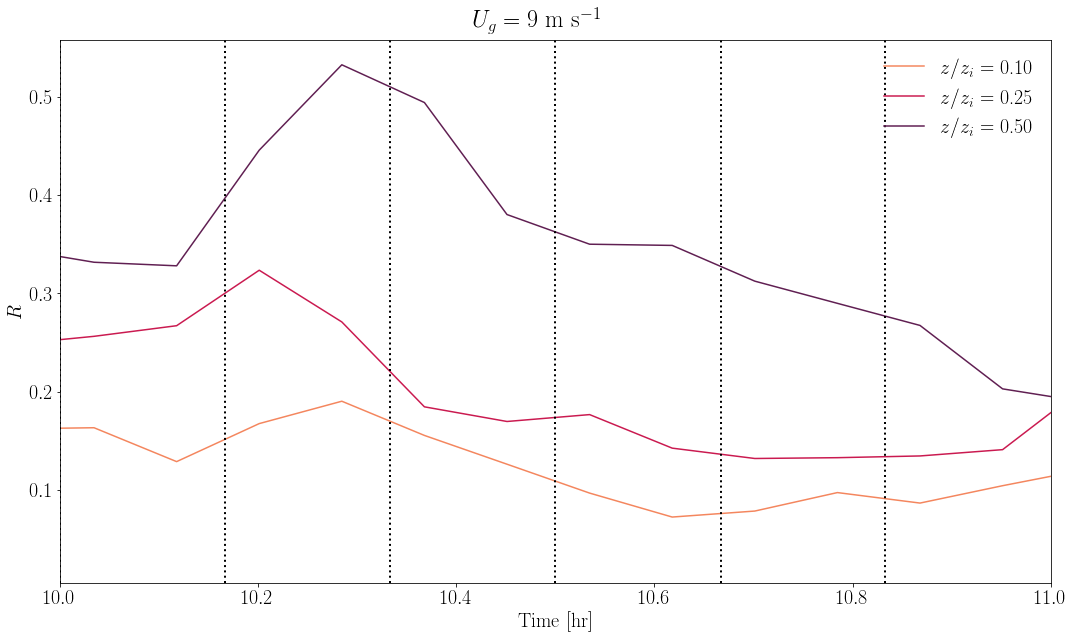

In [6]:
fig, ax = plt.subplots(figsize=(15,9))
# plot
ax.plot(r_10.time.coarsen(time=6, boundary="trim").mean(), r_10.coarsen(time=6, boundary="trim").mean(), label="$z / z_i$ = 0.10", c=colors[0])
ax.plot(r_25.time.coarsen(time=6, boundary="trim").mean(), r_25.coarsen(time=6, boundary="trim").mean(), label="$z / z_i$ = 0.25", c=colors[1])
ax.plot(r_50.time.coarsen(time=6, boundary="trim").mean(), r_50.coarsen(time=6, boundary="trim").mean(), label="$z / z_i$ = 0.50", c=colors[2])
# axis labels
ax.set_ylabel("$R$")
ax.set_xlabel("Time [hr]")
# axis limits
ax.set_xlim(10,11)
# vertical lines
times = [10,10.167,10.333,10.500,10.667,10.833]
[ax.axvline(x=t, c="k", ls=":", lw=2) for t in times]
# for tt, lab in zip(times, list("abcdef")):
#     ax.text(tt, 1.075, f"({lab})", fontsize=20, ha="center", va="bottom")
# legend
plt.legend(frameon=False)
# title
fig.suptitle("$U_g = 9$ m s$^{-1}$")
# layout
fig.tight_layout(pad=.5)
plt.show(fig)
plt.close()

In [ ]:
r_25